## Week 6: PyTorch
PyTorch is an open-source library designed for ML and DL. It allows for **tensor** manipulation, and is optimized for use on GPUs.

### Outline
We'll implement a simple feedforward network to learn about:
- Numpy vs PyTorch
- Autograd 

Most of the code below is adapted from [PyTorch's official tutorials](https://pytorch.org/tutorials).

### Feedforward network with NumPy
To illustrate why PyTorch is useful, we'll start by implementing a simple feedforward 2-layer network in raw NumPy. We'll use ReLU activation functions and update gradients with gradient descent (backprop).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# N is number of observations; D_in is input layer dimension;
# H is hidden layer dimension; D_out is output layer dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

In [0]:
# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

In [0]:
# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

In [0]:
def forward_pass_np(x, w1, w2):
  """function that computes the forward pass through the network 
  and returns y_pred"""
  # compute hidden layer input
  h = x.dot(w1)

  # compute hidden layer activation (ReLU)
  h_relu = np.maximum(h, 0)

  # compute output layer output
  y_pred = h_relu.dot(w2)
  
  return y_pred

In [0]:
def compute_loss_np(y, y_pred):
  """function that computes and returns squared error loss"""
  loss = np.square(y_pred - y).sum()
  
  return loss

In [0]:
# Backprop parameters
learning_rate = 1e-6
n_iters = 500
loss = np.zeros(n_iters)

In [0]:
for t in range(n_iters):
    # Forward pass: compute predicted y
    y_pred = forward_pass_np(x, w1, w2)

    # Compute and print loss
    loss[t] = compute_loss_np(y, y_pred)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = np.maximum(x.dot(w1), 0).T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[x.dot(w1) < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Text(0, 0.5, 'Total Loss')

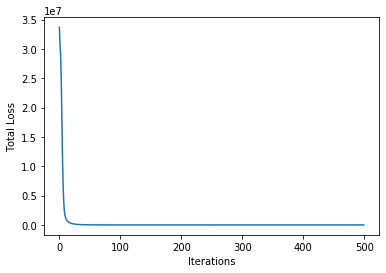

In [15]:
# plot loss over time
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Total Loss')

### PyTorch
PyTorch is designed to be *Pythonic*, and is heavily inspired by NumPy. For our purposes, there are three main differences:
- **Tensors** vs NumPy arrays
- GPU optimization
- Automatic differentiation


![alt text](https://miro.medium.com/max/2400/1*GbwKkmA0NdndXRhOOwNclA.jpeg)

In [0]:
import torch

In [17]:
# set PyTorch device to CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
# there are a few ways to instantiate a tensor
torch.tensor([[1, 2], [3, 4]])

tensor([[1, 2],
        [3, 4]])

In [19]:
# we can convert numpy arrays to tensors
torch.tensor(np.array([[1, 2, 3], [4, 5, 6]]))

tensor([[1, 2, 3],
        [4, 5, 6]])

In [20]:
# it can be very useful to specify a data type
dtype = torch.float
torch.ones([2, 2], dtype=dtype, device=device)

tensor([[1., 1.],
        [1., 1.]], device='cuda:0')

In [21]:
# we can index and slice tensors using normal python syntax
z = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(z[1][0])

z[0][0] = 50
print(z)

tensor(4)
tensor([[50,  2,  3],
        [ 4,  5,  6]])


In [22]:
# get a Python number using .item()
print(z[1][0].item())

# get shape of tensor
print(z.shape)

# operations are different under the hood but have the same syntax
print(z**2)
print(z.pow(2))

4
torch.Size([2, 3])
tensor([[2500,    4,    9],
        [  16,   25,   36]])
tensor([[2500,    4,    9],
        [  16,   25,   36]])


### Feedforward network with PyTorch
Now we'll implement the same network with PyTorch. For now we'll still manually compute the gradient.

In [0]:
# N is number of observations; D_in is input layer dimension;
# H is hidden layer dimension; D_out is output layer dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

In [0]:
# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

In [0]:
# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

In [26]:
# we need to update our functions to handle tensors
forward_pass_np(x, w1, w2)

RuntimeError: ignored

In [0]:
def forward_pass(x, w1, w2):
  """function that computes the forward pass through the network 
  and returns y_pred"""
  # compute hidden layer input
  # h = x.dot(w1)
  h = x.mm(w1)

  # compute hidden layer activation (ReLU)
  # h_relu = np.maximum(h, 0)
  h_relu = h.clamp(min=0)

  # compute output layer output
  # y_pred = h_relu.dot(w2)
  y_pred = h_relu.mm(w2)
  
  return y_pred

In [0]:
def compute_loss(y, y_pred):
  """function that computes and returns squared error loss"""
  loss = (y_pred - y).pow(2).sum()
  
  return loss

In [0]:
# Backprop parameters
learning_rate = 1e-6
n_iters = 500
loss = np.zeros(n_iters)

In [42]:
for t in range(n_iters):
    # Forward pass: compute predicted y
    y_pred = forward_pass(x, w1, w2)

    # Compute and print loss
    loss[t] = compute_loss(y, y_pred).item()

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = x.mm(w1).clamp(min=0).t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[x.mm(w1) < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

RuntimeError: ignored

Text(0, 0.5, 'Total Loss')

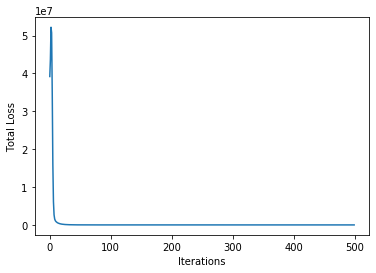

In [32]:
# plot loss over time
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Total Loss')

### With autograd
We'll now let PyTorch's autograd function handle the gradients automatically, but we'll still manually update the gradients.

In [0]:
# N is number of observations; D_in is input layer dimension;
# H is hidden layer dimension; D_out is output layer dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

In [0]:
# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

In [0]:
# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

In [0]:
# Backprop parameters
learning_rate = 1e-6
n_iters = 1000
store_loss = np.zeros(n_iters) # THIS HAS CHANGED

In [0]:
for t in range(n_iters):
  # Forward pass: compute predicted y
  y_pred = forward_pass(x, w1, w2)

  # Compute and print loss
  loss = compute_loss(y, y_pred)
  store_loss[t] = loss.item()

  # Use autograd to compute the backward pass.
  loss.backward()

  # Update weights using gradient descent
  with torch.no_grad():
      w1 -= learning_rate * w1.grad
      w2 -= learning_rate * w2.grad

      # Manually zero the gradients after updating weights
      w1.grad.zero_()
      w2.grad.zero_()

Text(0, 0.5, 'Total Loss')

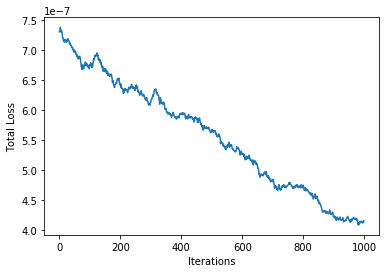

In [60]:
# plot loss over time
plt.plot(store_loss)
plt.xlabel('Iterations')
plt.ylabel('Total Loss')

### With autograd, we can forget about chain rule, partial derivatives, etc
When we create a tensor and set `.requires_autograd=True`, PyTorch starts tracking all operations that act on that tensor.

In [89]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [90]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [91]:
print(y.grad_fn)

In [92]:
z = y * y * 3
o = z.mean()

print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


In [0]:
# backpropagate to compute all gradients
o.backward()

In [94]:
# print gradients: d(z_out)/dz
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### Why is our gradient a matrix of 4.5?
$$o = \frac{1}{4}\sum_iz_i$$

$$z_i = 3(x_i + 2)^2 $$

$$z_i|_{x_i=1} = 27$$

$$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i + 2) $$

$$\frac{\partial o}{\partial x_i}|_{x_i=1} = \frac{9}{2} = 4.5 $$

In [110]:
# non-scalar example
x = torch.ones(3, requires_grad=True)
y = x * 2

for i in range(5):
  y = y * 2

print(y)

tensor([64., 64., 64.], grad_fn=<MulBackward0>)


In [103]:
y.backward()

RuntimeError: ignored

In [0]:
y.backward(torch.ones(3))

In [112]:
print(x.grad)

tensor([64., 64., 64.])


In [114]:
x = torch.ones(3, requires_grad=True)
y = x * 2

for i in range(5):
  y = y * 2

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([6.4000e+00, 6.4000e+01, 6.4000e-03])


## Next week:
There's a **lot** more to PyTorch. Moving forward, we will learn about the `nn` and `optimize` packages. 

### Mess around!
Try messing with:
- actual input/output functions
- network structure
- backprop parameters

In [0]:
# N is number of observations; D_in is input layer dimension;
# H is hidden layer dimension; D_out is output layer dimension.
N, D_in, H, D_out = 64, 5, 1000, 1

In [0]:
# Create input and output data
b = torch.tensor([1, 2, 3, 4, 5], dtype=dtype, device=device).reshape(5,1)

def true_func(x, b):
  y = x.mm(b)
  return y


In [0]:
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = true_func(x, b)

In [0]:
# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

In [0]:
# Backprop parameters
learning_rate = 1e-6
n_iters = 500
store_loss = np.zeros(n_iters)

In [0]:
for t in range(n_iters):
  # Forward pass: compute predicted y
  y_pred = forward_pass(x, w1, w2)

  # Compute and print loss
  loss = compute_loss(y, y_pred)
  store_loss[t] = loss.item()

  # Use autograd to compute the backward pass.
  loss.backward()

  # Update weights using gradient descent
  with torch.no_grad():
      w1 -= learning_rate * w1.grad
      w2 -= learning_rate * w2.grad

      # Manually zero the gradients after updating weights
      w1.grad.zero_()
      w2.grad.zero_()

Text(0, 0.5, 'Total Loss')

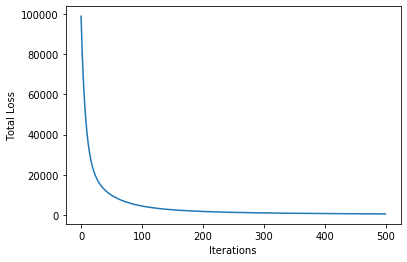

In [158]:
# plot loss over time
plt.plot(store_loss)
plt.xlabel('Iterations')
plt.ylabel('Total Loss')